# KTR Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.ktrlite import KTRLiteMAP

from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components, plot_ktr_lev_knots
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
# # from 2000-01-01 to 2008-12-31
# df = load_electricity_demand()

# date_col = 'date'
# response_col = 'electricity'
# df.dtypes

# df = df[df[date_col] >= '2006-01-01']
# df[response_col] = np.log(df[response_col])

# print(df.shape)
# df.head()

In [5]:
df = pd.read_csv("./data/melbourne-daily-min-temperatures.csv", parse_dates=['Date'])
date_col = 'Date'
response_col = 'Temp'
df[response_col] = np.log(1 + df[response_col])
df.head()

,Date,Temp
0,1981-01-01,3.07731
1,1981-01-02,2.93916
2,1981-01-03,2.98568
3,1981-01-04,2.74727
4,1981-01-05,2.82138


In [9]:
print(f'starts with {df[date_col].min()}\nends with {df[date_col].max()}\nshape: {df.shape}')

starts with 1981-01-01 00:00:00
ends with 1990-12-31 00:00:00
shape: (3650, 2)


### Train / Test Split

In [10]:
test_size=365
train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [14]:
# level_knot_dates = pd.date_range(start='1981-01-01', end='1990-12-31', periods=21)
# level_knot_dates

In [15]:
ktrlite = KTRLiteMAP(
    response_col=response_col,
    date_col=date_col,
    # seasonality
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.5,
    span_level=.1,
    # level_knot_dates=level_knot_dates,
    # date_freq='D',
    span_coefficients=.3,
    rho_coefficients=.15,
    estimator_type=StanEstimatorMAP,
)

In [16]:
ktrlite.fit(train_df)

In [17]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)
predicted_df.head()

,Date,prediction,trend,seasonality_7,seasonality_365.25
0,1990-01-01,2.68499,2.40627,0.00943,0.26929
1,1990-01-02,2.66810,2.40627,-0.00697,0.26879
2,1990-01-03,2.66311,2.40627,-0.01148,0.26832
3,1990-01-04,2.68225,2.40627,0.00808,0.26790
4,1990-01-05,2.68187,2.40627,0.00806,0.26754


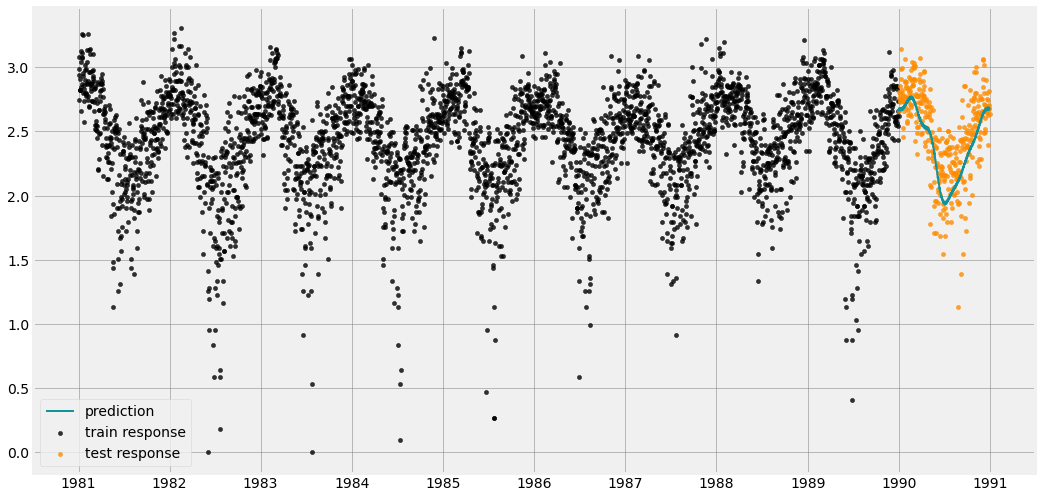

In [18]:
_ = plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=date_col, actual_col=response_col, 
                    test_actual_df=test_df)

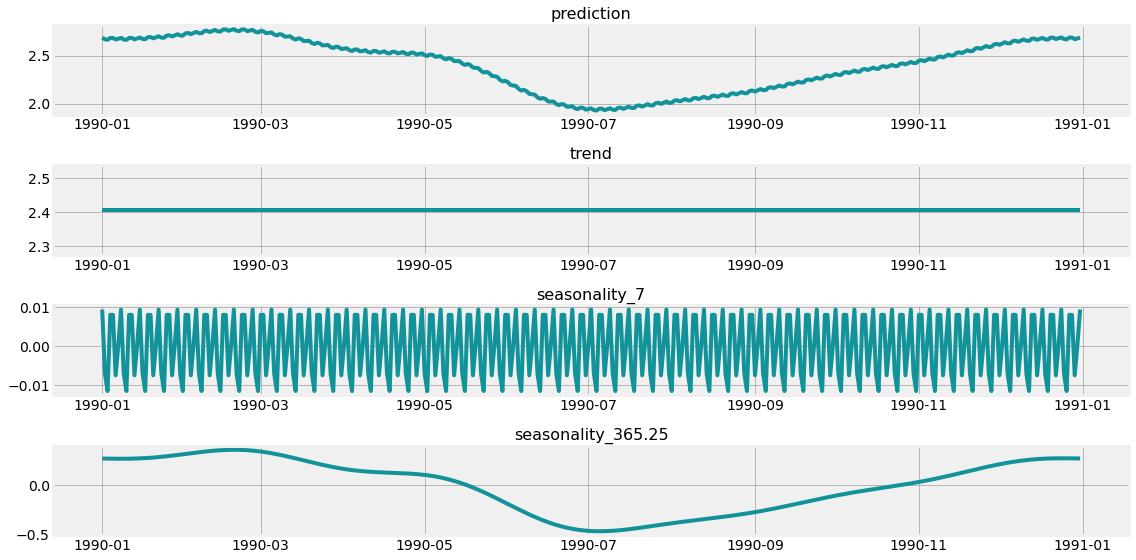

In [20]:
_ = plot_predicted_components(predicted_df=predicted_df, date_col=date_col, 
                          plot_components=['prediction', 'trend', 'seasonality_7', 'seasonality_365.25'])

In [21]:
# get the knots
lev_knots = ktrlite._aggregate_posteriors['map']['lev_knot']
lev_knots_tp_discrete = ktrlite._knots_tp_level * train_df.shape[0] - 1
td = pd.Series([pd.Timedelta(days=k) for k in lev_knots_tp_discrete])
lev_knot_dates = train_df[date_col].iloc[0] + td

full_df = pd.concat((train_df, test_df), axis=0, ignore_index=True)
decomp_df = ktrlite.predict(df=full_df, decompose=True)

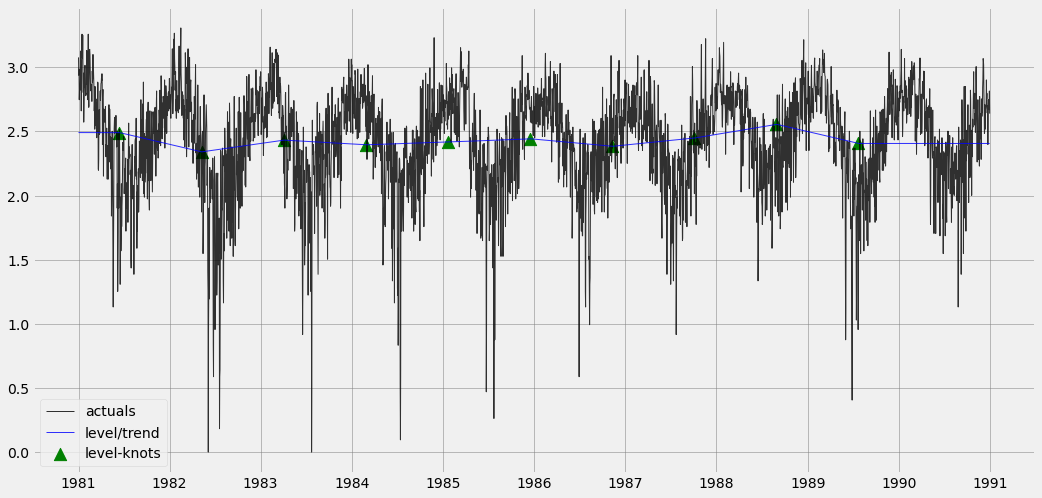

In [22]:
_ = plot_ktr_lev_knots(full_df, decomp_df, date_col, response_col, lev_knot_dates, lev_knots)